In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import robofish.io

In [35]:
fishes = 4

In [38]:
from sklearn.mixture import GaussianMixture
import sklearn.cluster as cl
import sklearn.metrics as mt

class EMAlgorithmFishModel(fish_models.gym_interface.AbstractRaycastBasedModel):
    def __init__(self):
        """
        Representation of a Gaussian mixture model probability distribution. 
        GMMs are probabilistic models that assume all the data points are generated 
        from a mixture of several Gaussian distributions with unknown parameters.
        
        The EM algorithm is an iterative approach that cycles between two modes:
        E-Step. Estimate the missing variables in the dataset.
        M-Step. Maximize the parameters of the model in the presence of the data.
        """
    
    def choose_action(self, view: np.ndarray):
        
        prediction = self.model.predict([view])
        
        print(prediction)
        print(self.model.get_params())
        
        speed = prediction[0]
        turn = prediction[1]
        
        # turn correction for walls avoidance
        turn = self.avoid_walls(view, turn)
        
        return speed, turn
    
    def avoid_walls(self, view, turn):
        """
        Forces to turn a fish in a random direction
        if in a view's raycast of the walls
        a wall in the front of a fish is detected to near

        Parameters
        ---------
        view : array_like
            The observations of the virtual fish
        turn : float
            Turn predicted by a model that is to modify

        Returns
        ---------
        turn : float
            Original or modified turn depending on the wall distance
        """
        param = random.randint(-5, 5)
        
        if param == 0:
            param = random.randint(5, 11)
        
        if view[6] > 0.9:
            return param * np.pi
        else:
            return turn
        
    def learn_params(self, X_labeled, y_labeled):
        """
        Learns the initial parameters from the labeled data. 
        These learned parameters are used in the first E step.
        """
        n = X_labeled.shape[0]
        phi = X_labeled[y_labeled == 1].shape[0] / n
        mu0 = np.sum(X_labeled[y_labeled == 0], axis=0) / X_labeled[y_labeled == 0].shape[0]
        mu1 = np.sum(X_labeled[y_labeled == 1], axis=0) / X_labeled[y_labeled == 1].shape[0]
        sigma0 = np.cov(X_labeled[y_labeled == 0].T, bias= True)
        sigma1 = np.cov(X_labeled[y_labeled == 1].T, bias=True)
        return {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}

    
    def e_step(self, X, params):
        """
        Calculates with the initialized parameters 
        the heuristics Q(y=1|x) and Q(y=0|x) 
        for every data point as well as the average log-likelihoods 
        which will be maximized in the M step.
        """
        np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(X),
                stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X)])
        log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(X),
                stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X)]).T
        log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
        return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])
    
    
    def m_step(self, X, params):
        """
        In m_step() the parameters are updated.
        """
        total_count = X.shape[0]
        _, heuristics = e_step(X, params)
        heuristic0 = heuristics[:, 0]
        heuristic1 = heuristics[:, 1]
        sum_heuristic1 = np.sum(heuristic1)
        sum_heuristic0 = np.sum(heuristic0)
        phi = (sum_heuristic1/total_count)
        mu0 = (heuristic0[..., np.newaxis].T.dot(X)/sum_heuristic0).flatten()
        mu1 = (heuristic1[..., np.newaxis].T.dot(X)/sum_heuristic1).flatten()
        diff0 = X - mu0
        sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
        diff1 = X - mu1
        sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
        params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
        return params
    
    def get_avg_log_likelihood(self, X, params):
        loglikelihood, _ = self.e_step(X, params)
        return np.mean(loglikelihood)


    def run_em(self, x, params):
        """
        Repeats running the two steps until the average log-likelihood converges. 
        rum_em() returns the predicted labels, the posteriors and 
        average log-likelihoods from all training steps.
        """
        avg_loglikelihoods = []
        while True:
            avg_loglikelihood = get_avg_log_likelihood(x, params)
            avg_loglikelihoods.append(avg_loglikelihood)
            if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
                break
            params = m_step(x, params)
        print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
                   % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
        _, posterior = e_step(x, params)
        forecasts = np.argmax(posterior, axis=1)
        return forecasts, posterior, avg_loglikelihoods
    
    def fit(self, dset):
        """
        Learns parameters and runs the the two steps of EM Algorithm 
        until the average log-likelihood converges.
        """
        
        X = dset[:]["views"]
        y = dset[:]["actions"]
        
        # Fit
        learned_params = self.learn_params(X, y)
        
        forecasts, posterior, loglikelihoods = self.run_em(X, learned_params)

        
    
model = EMFishModel()

In [39]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [40]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data from 5 files.


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating views from 5 files.


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

Created IoDataset:
Reduced the first 3 dimensions from (5, 2, 8989) to (89890)
poses	(89890, 3):	consisting of x, y, calc_ori_rad.
actions	(89880, 2):	consisting of speed[cm/s] and turn [rad/s].
views	(89880, 9):	4 fish_bins and 5 wall ray casts.



In [41]:
model.fit(dset)

generator = fish_models.gym_interface.TrackGeneratorGymRaycast(
    model, raycast, [100,100], 25
)

track = generator.create_track(n_guppies=fishes, trackset_len=5000)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 9 but corresponding boolean dimension is 2

In [9]:
f = generator.as_io_file(track)
f.save_as("output/em_algorithm.hdf5")

<HDF5 file "8b3c9eb7-54bd-422c-ba65-7da4f8baf328" (mode r+)>

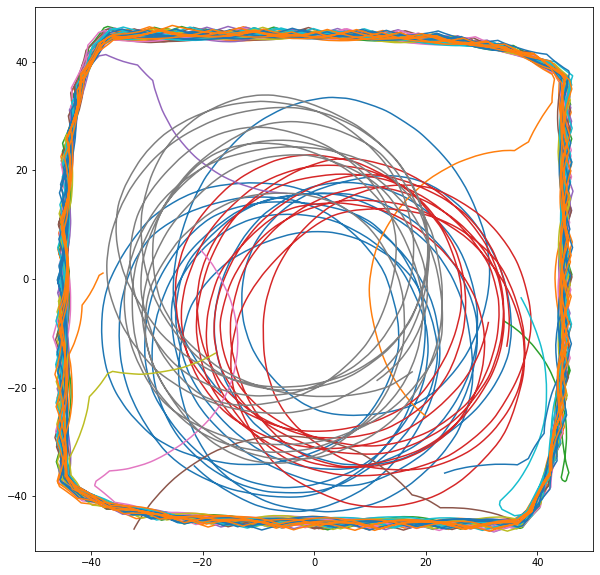

In [10]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [11]:
def calculate_speed_from_position(track):
    speed = []
    
    for i in range(track.shape[1] - 1):
        s = ((track[0, i + 1, 0] - track[0, i, 0])**2 + (track[0, i + 1, 1] - track[0, i, 1])**2)**0.5
        speed.append(s)
    
    return np.array(speed)


In [12]:
speed = calculate_speed_from_position(track)
print(speed.shape)
print(speed.ndim)

bins = np.arange(start=0, stop=2, step=0.01)


(2999,)
1


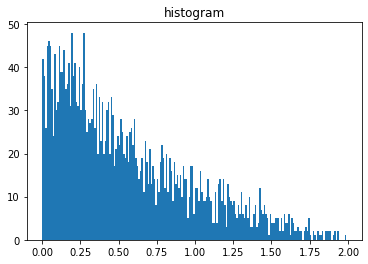

In [13]:
plt.hist(speed, bins) 
plt.title("histogram") 
plt.show()